# Instrução do Projeto

A Film Junky Union, uma nova comunidade para entusiastas de filmes clássicos, está desenvolvendo um sistema para filtrar e categorizar resenhas de filmes. O objetivo é treinar um modelo para detectar automaticamente resenhas negativas. Você usará um conjunto de dados de resenhas de filmes do IMDB com rotulagem de polaridade para criar um modelo para classificar resenhas como positivas e negativas. Ele precisará ter um valor F1 de pelo menos 0,85.

## Inicialização

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# isso é para usar progress_apply, leia mais em https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Carregar Dados

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## AED

Vamos verificar o número de filmes e resenhas ao longo dos anos.

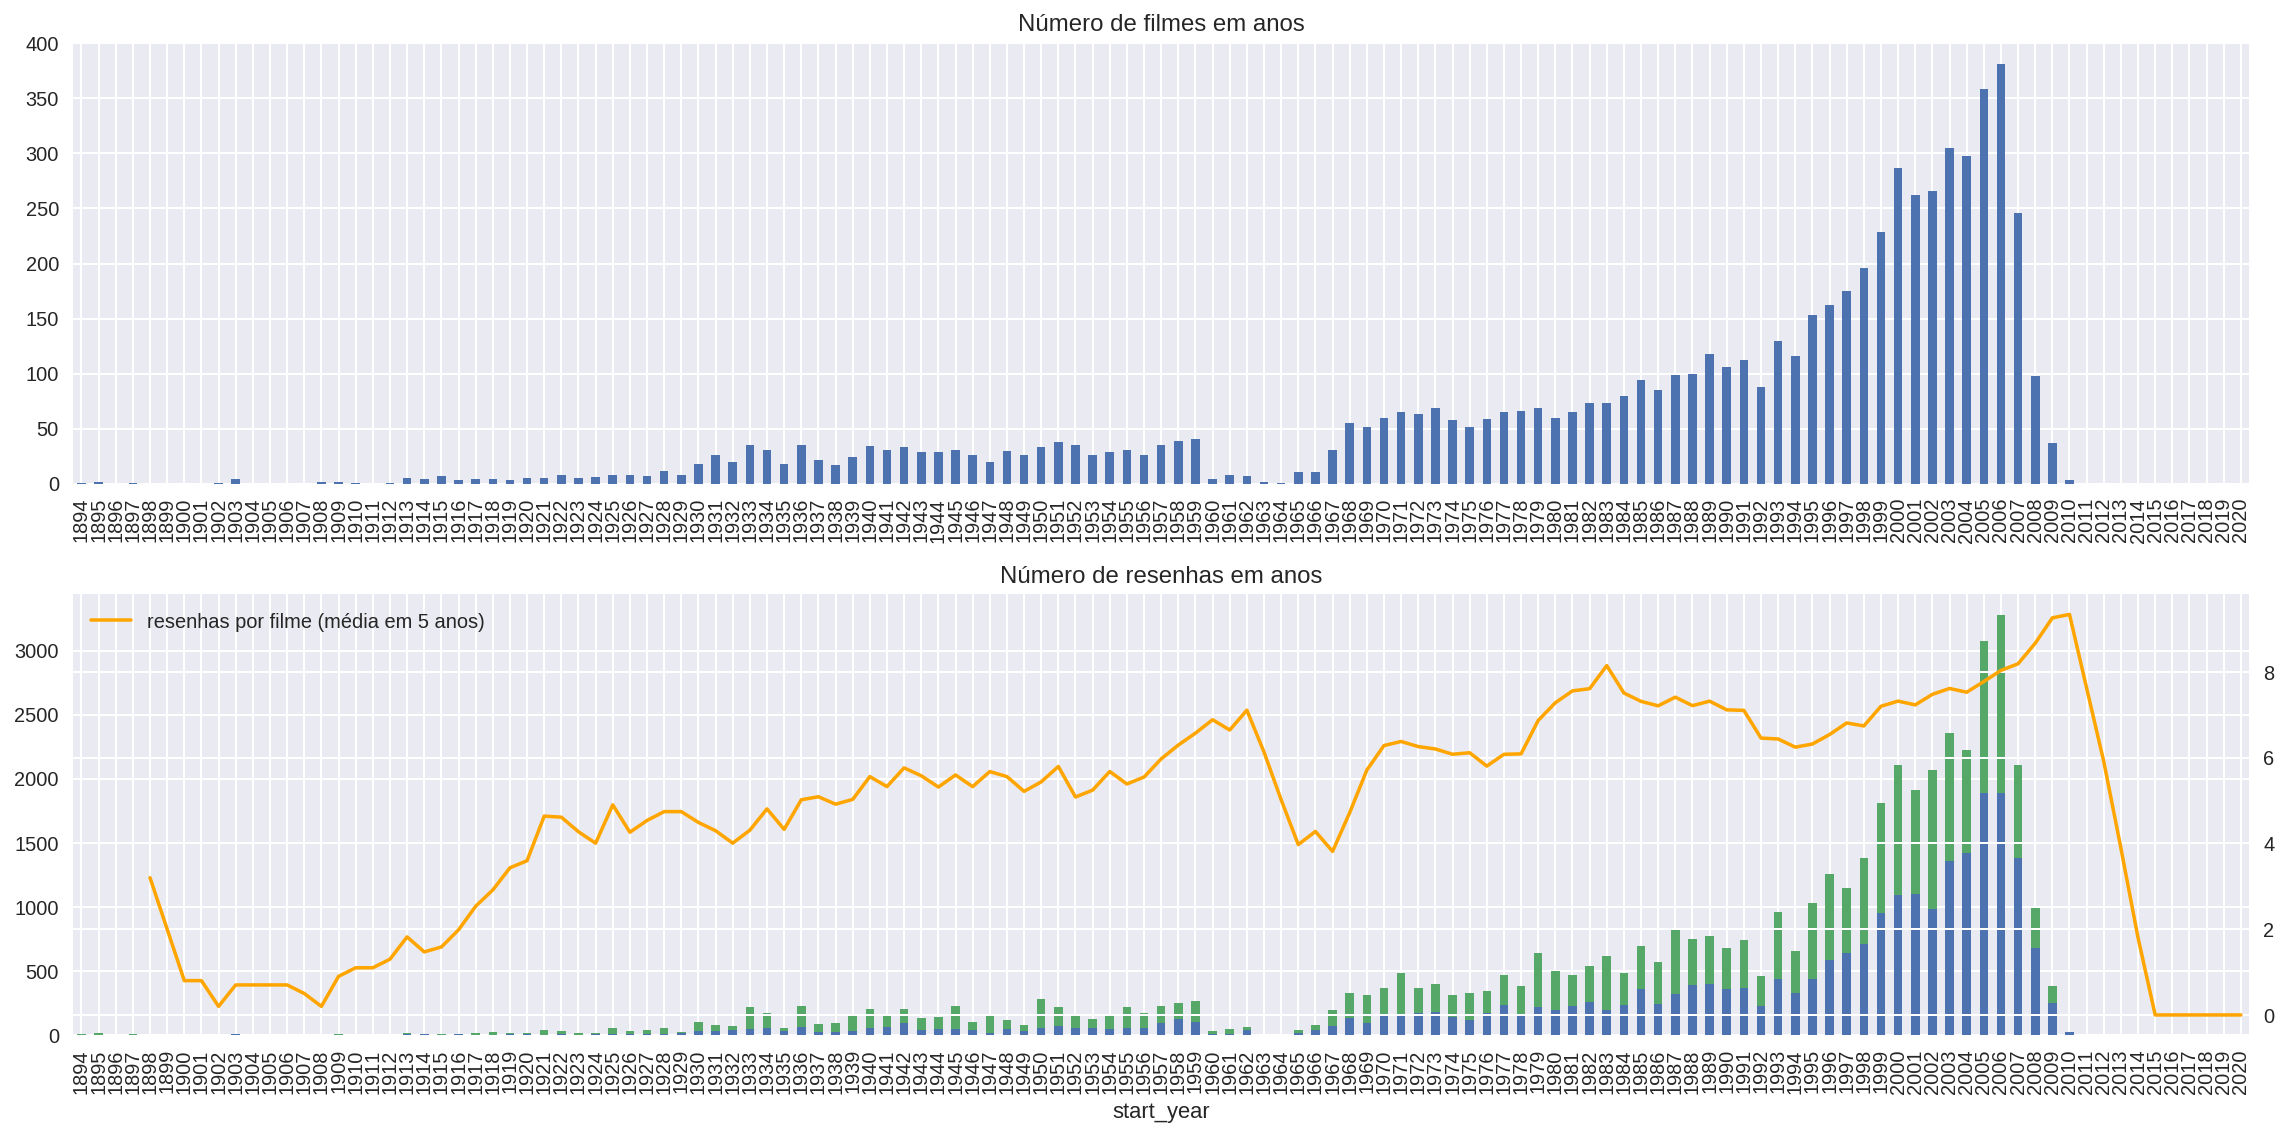

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de filmes em anos')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='resenhas por filme (média em 5 anos)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de resenhas em anos')

fig.tight_layout()

Vamos verificar a distribuição do número de resenhas por filme com a contagem exata e o EDK (Estimativa de densidade kernel - só para saber como pode diferir da contagem exata)

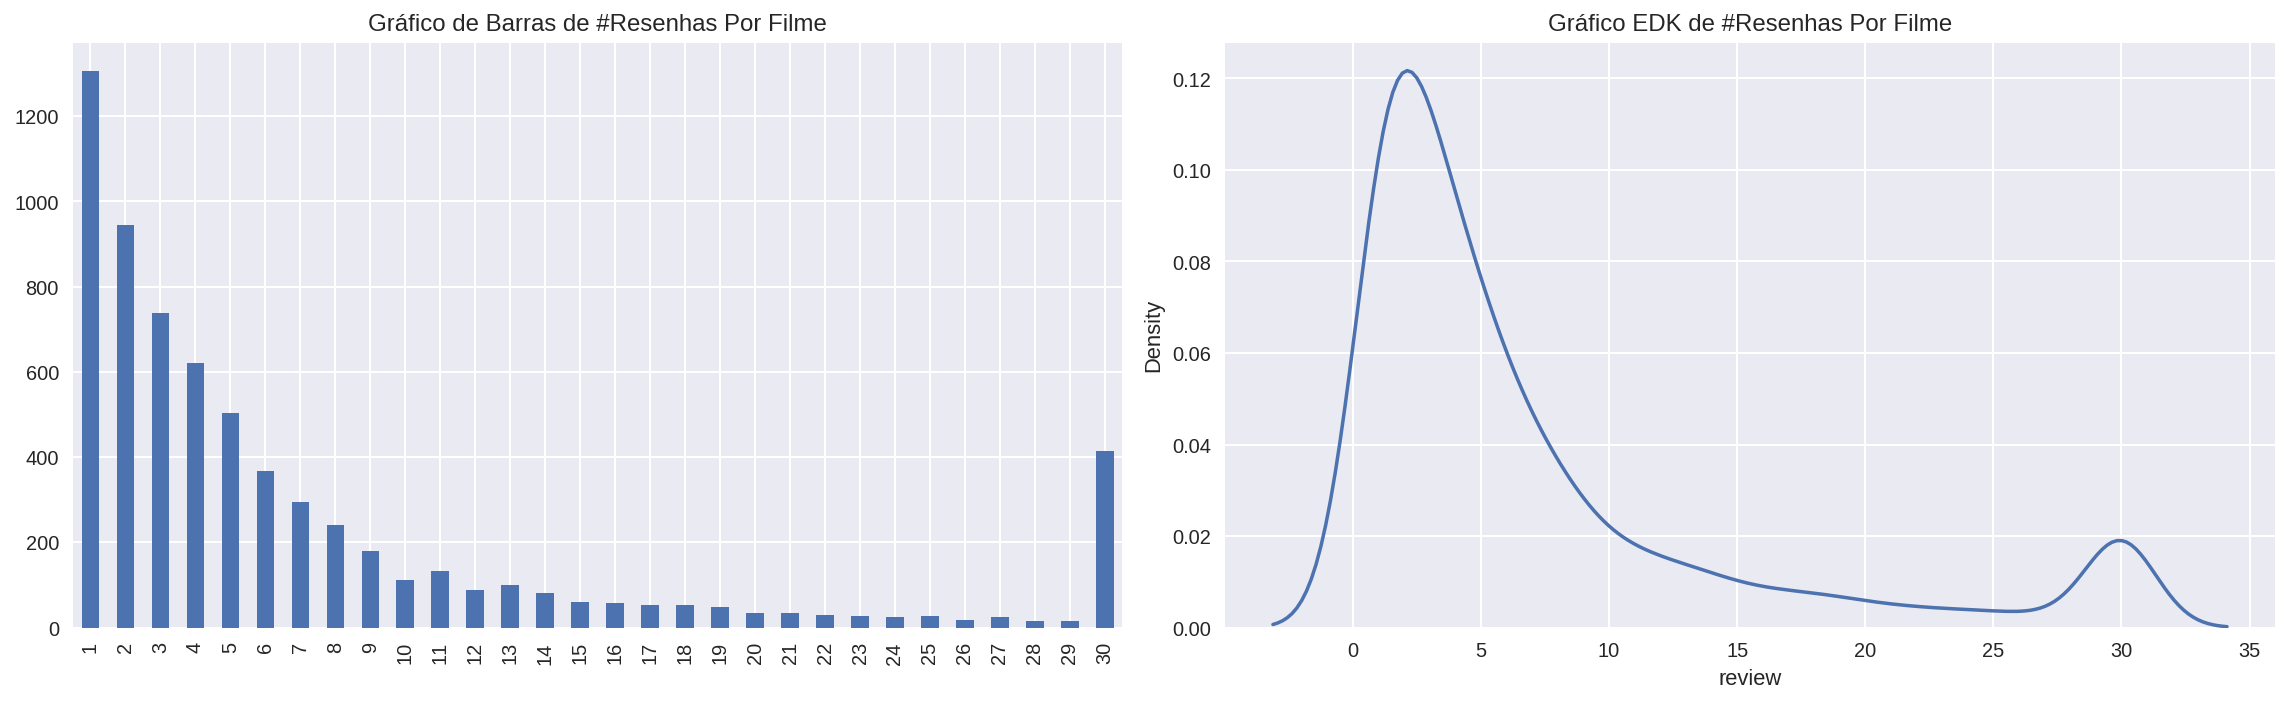

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de Barras de #Resenhas Por Filme')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico EDK de #Resenhas Por Filme')

fig.tight_layout()

In [7]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

Com base na contagem de valores da coluna "pos" do dataframe "df_reviews", podemos ver que há um equilíbrio quase perfeito entre as classes positivas e negativas. Existem 23.715 avaliações negativas e 23.616 avaliações positivas, o que indica que não há um desequilíbrio significativo de classe nos dados. Isso pode ser considerado uma boa notícia para a tarefa de modelagem, pois não precisaremos nos preocupar com a necessidade de lidar com um desequilíbrio de classe significativo.

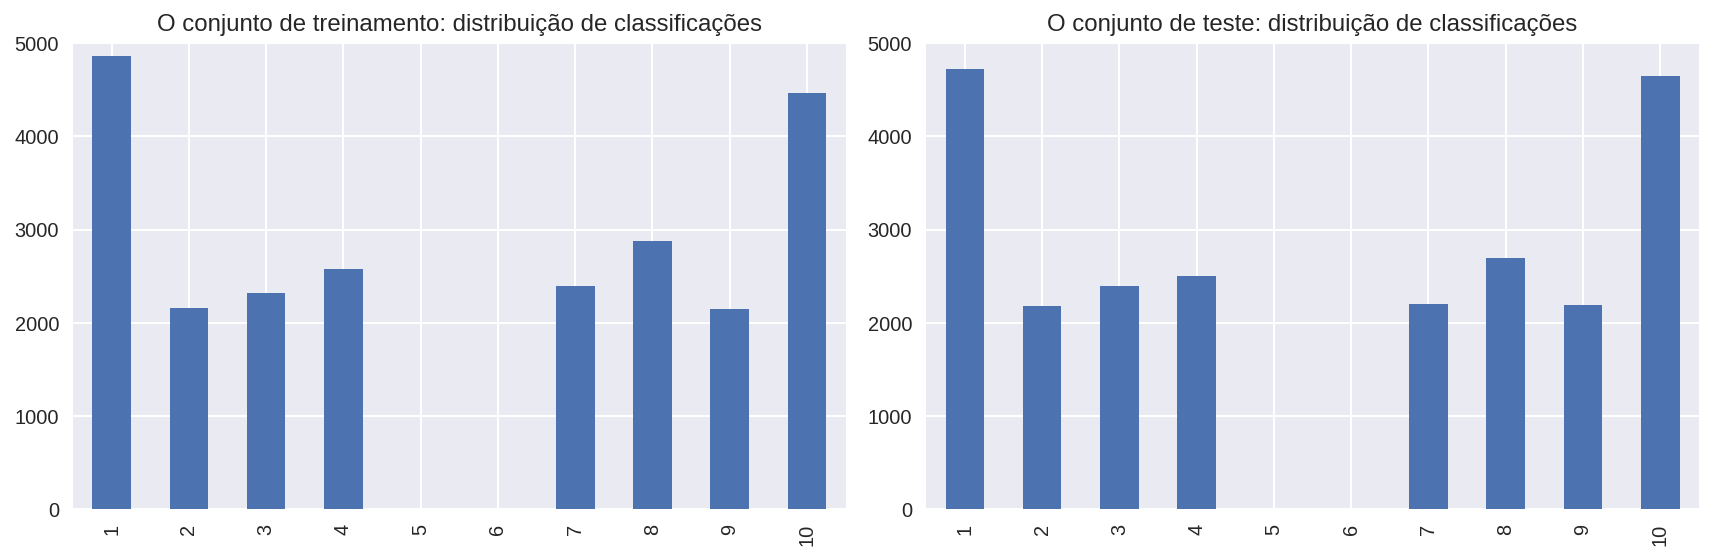

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de treinamento: distribuição de classificações')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de teste: distribuição de classificações')

fig.tight_layout()

Distribuição de resenhas negativas e positivas ao longo dos anos para duas partes do conjunto de dados

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


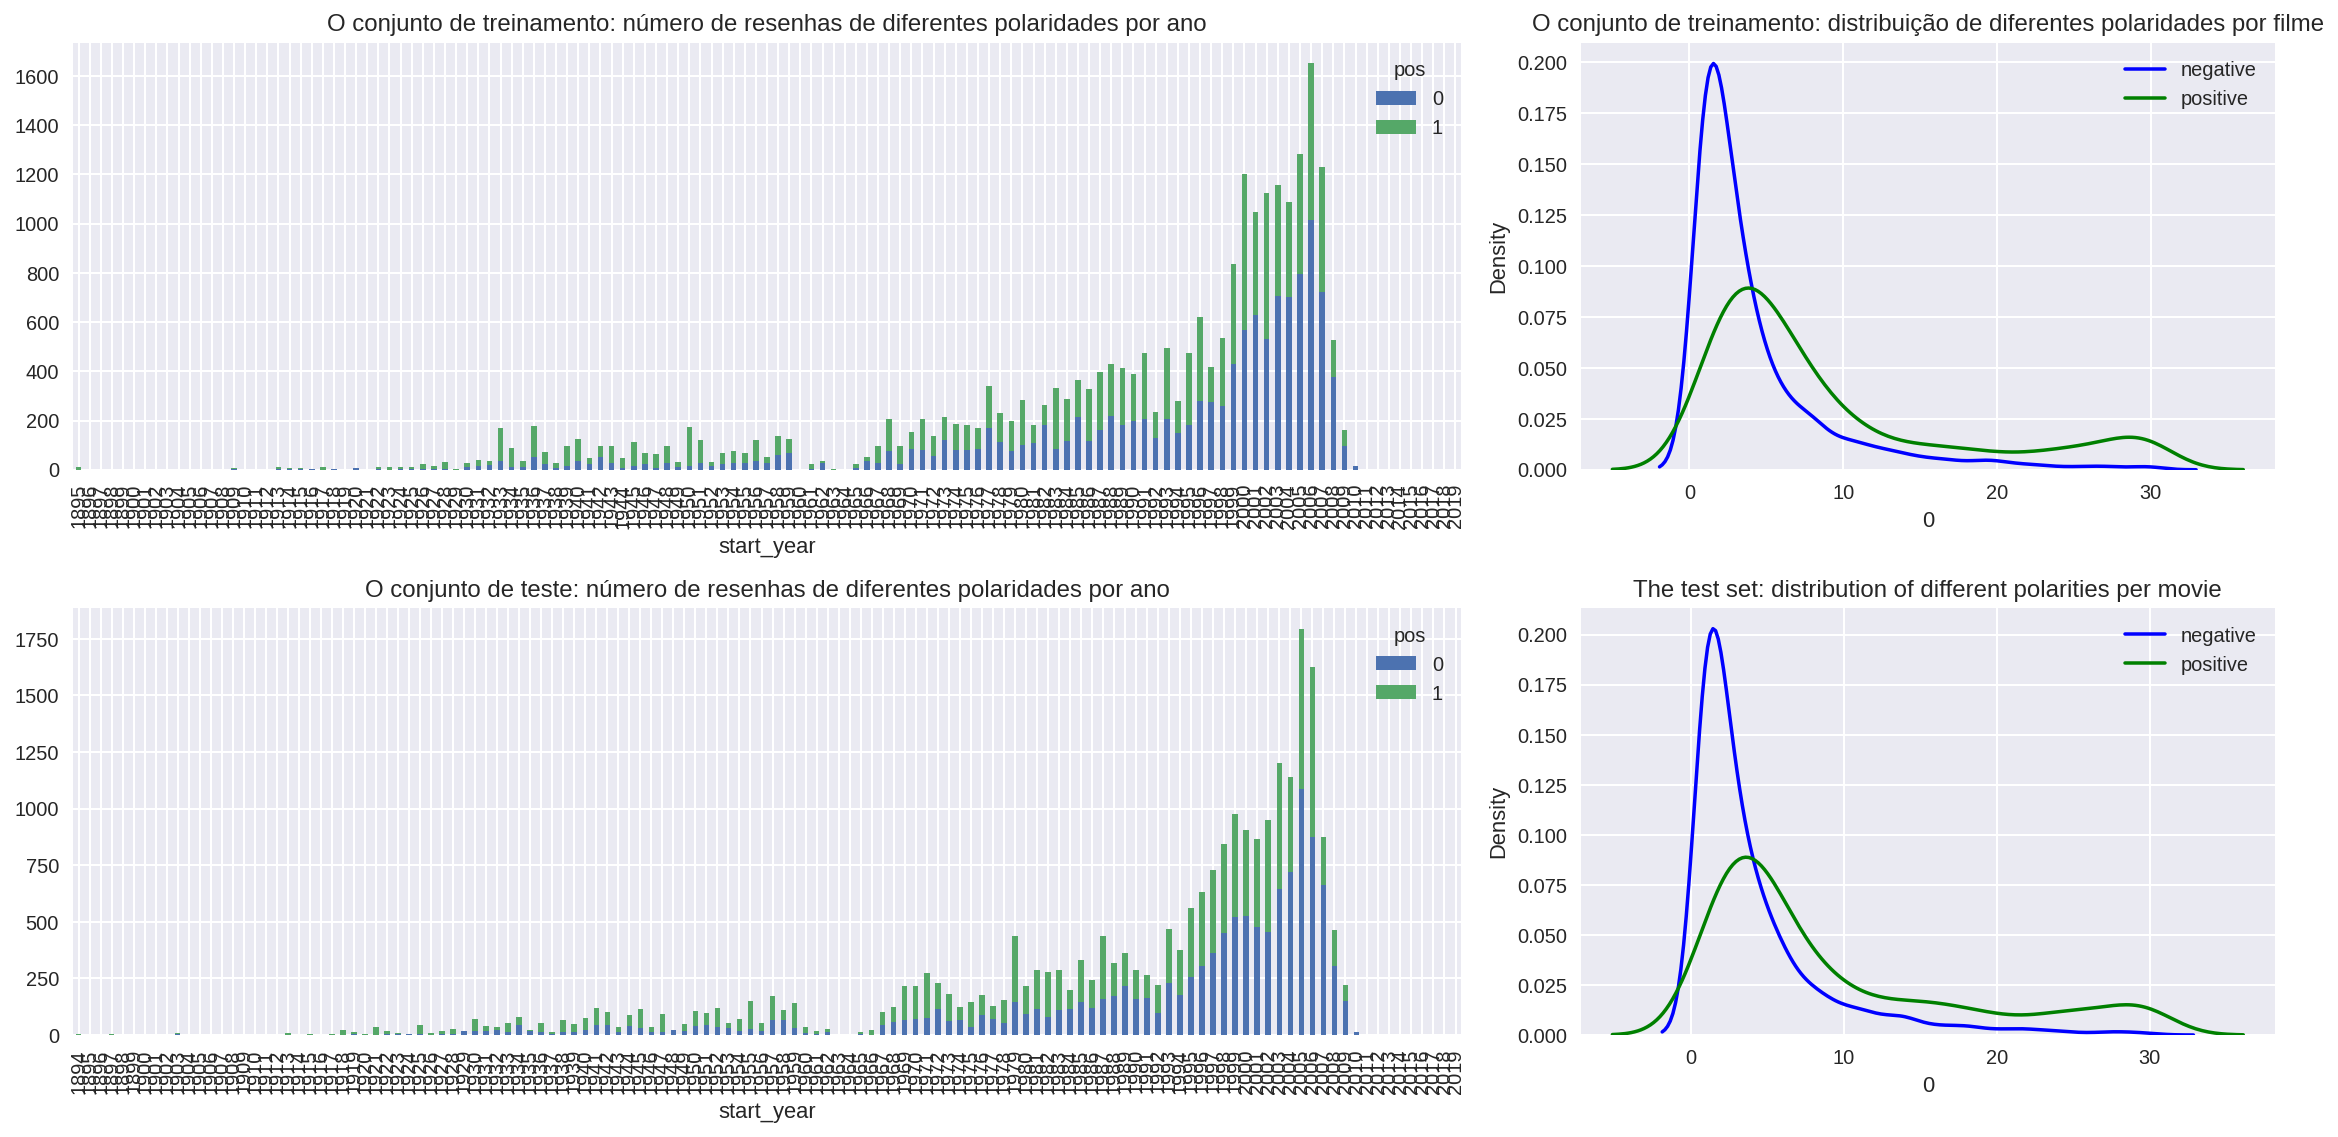

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de treinamento: número de resenhas de diferentes polaridades por ano')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('O conjunto de treinamento: distribuição de diferentes polaridades por filme')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de teste: número de resenhas de diferentes polaridades por ano')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Procedimento de Avaliação

Compondo uma rotina de avaliação que pode ser utilizada para todos os modelos deste projeto

In [10]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Curva de precisão-revocação
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # Curva de precisão-revocação
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.vreindex(index=('Acurácia', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalização

Assumimos que todos os modelos abaixo aceitam textos em letras minúsculas e sem dígitos, sinais de pontuação, etc.

In [11]:
import re

def normalize_text(text):
    """
    Normaliza o texto para letras minúsculas e remove dígitos, sinais de pontuação e caracteres especiais.
    """
    # Converter o texto para minúsculas
    text = text.lower()
    
    # Remover dígitos, sinais de pontuação e caracteres especiais usando expressões regulares
    text = re.sub(r'\d+', '', text)  # Remove dígitos
    text = re.sub(r'[^\w\s]', '', text)  # Remove sinais de pontuação e caracteres especiais
    
    return text

In [12]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

In [13]:
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um  a serious film about troubled teens in sin...
4        im totally agree with garryjohal from singapor...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought id say this about a biopic but...
47329    spirit and chaos is an artistic biopic of miya...
47330    ill make this brief this was a joy to watch it...
Name: review_norm, Length: 47331, dtype: object

## Treinar / Testar Conjunto

Felizmente, todo o conjunto de dados já está dividido em partes de treinamento/teste. A opção correspondente é 'ds_part'.

In [14]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabalhando com modelos

### Modelo 0 - Constante

In [15]:
from sklearn.dummy import DummyClassifier

# Definir o modelo DummyClassifier
model_dummy = DummyClassifier(strategy='constant', constant=1)

# Treinar o modelo com os dados de treinamento
model_dummy.fit(df_reviews_train['review_norm'], train_target)

# Fazer previsões com o modelo
predicoes_train = model_dummy.predict(df_reviews_train['review_norm'])
predicoes_test = model_dummy.predict(df_reviews_test['review_norm'])

# Avaliar a acurácia do modelo
acc_train = (predicoes_train == train_target).mean()
acc_test = (predicoes_test == test_target).mean()

print("Acurácia no conjunto de treinamento:", acc_train)
print("Acurácia no conjunto de teste:", acc_test)

Acurácia no conjunto de treinamento: 0.4994116658261893
Acurácia no conjunto de teste: 0.4984916082430423


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS         0.5   0.5
ROC AUC     0.5   0.5


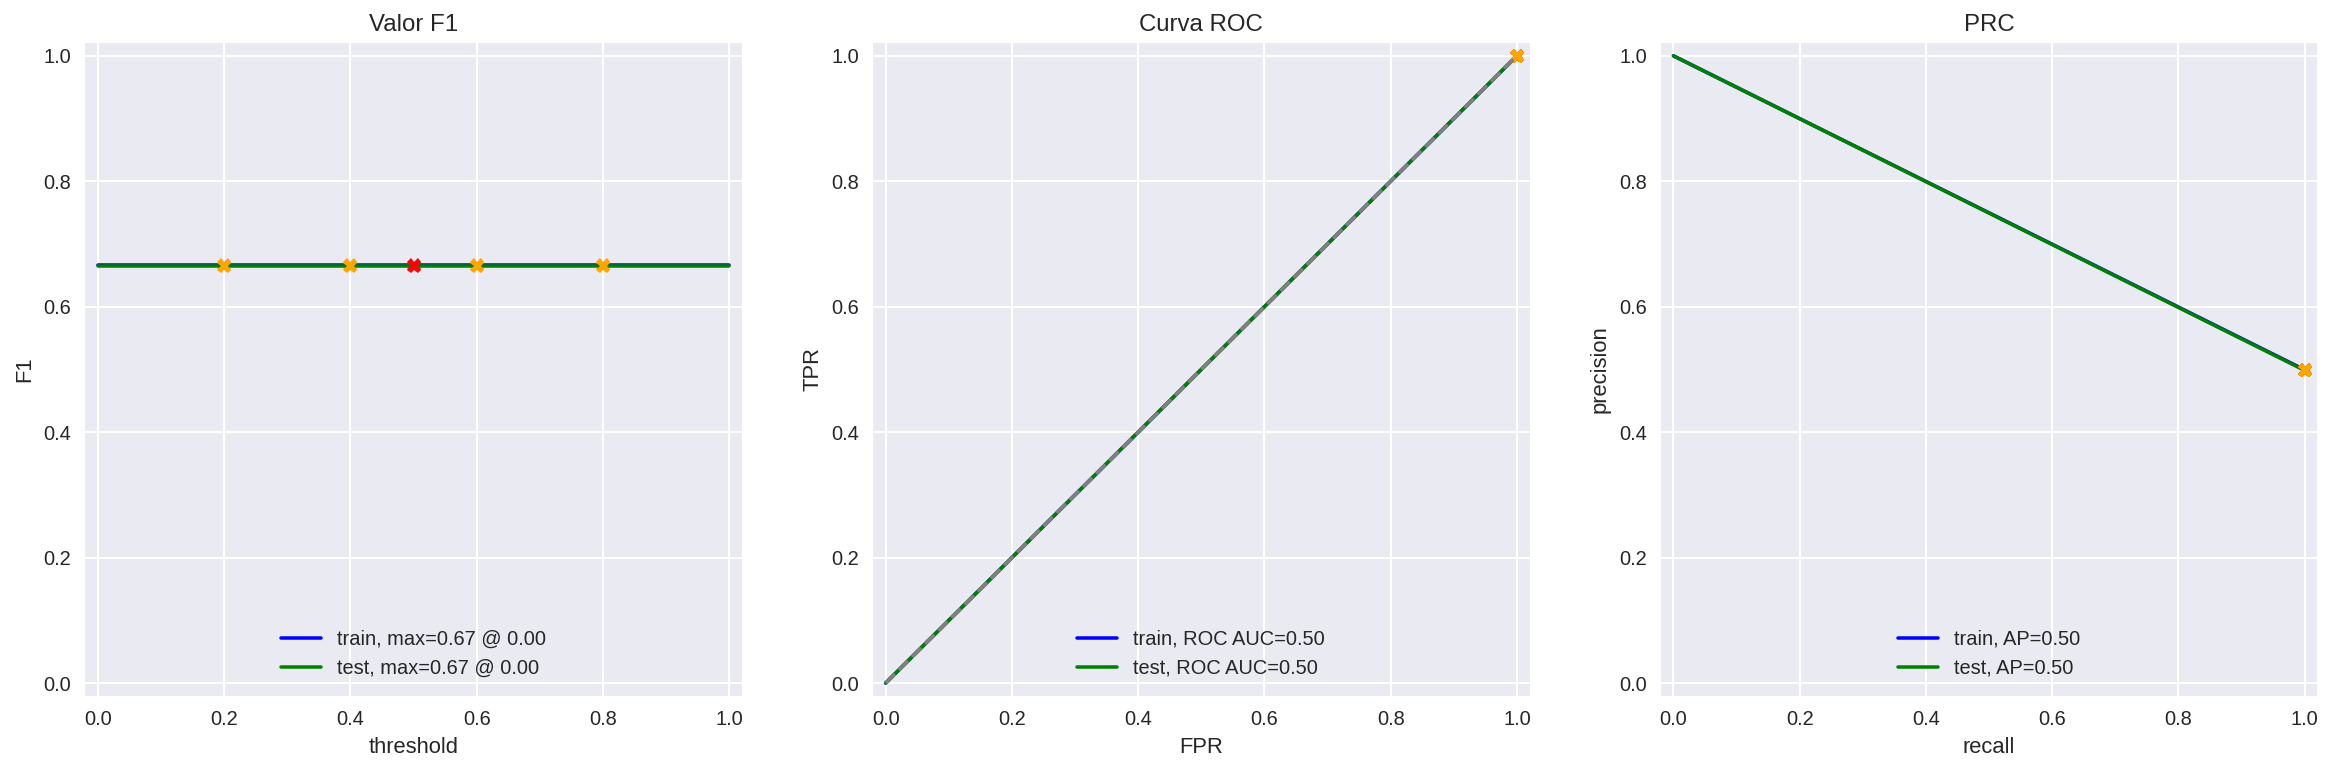

In [16]:
evaluate_model(model_dummy, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)

### Modelo 1 - NLTK, TF-IDF e Regressão Linear

TF-IDF

In [17]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

# criar vetorizador TF-IDF
tfidf1 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)

# Obter as matrizes de features para os dados de treinamento e teste
train_features = tfidf1.fit_transform(df_reviews_train['review_norm'])
test_features = tfidf1.transform(df_reviews_test['review_norm'])

# Criar um modelo de Regressão Logística
model1 = LogisticRegression()

# Treinar o modelo usando as matrizes de features e as variáveis de destino
model1.fit(train_features, train_target)

# Fazer previsões para os dados de teste
y_pred_lr = model1.predict(test_features)

          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.98  0.95
ROC AUC    0.98  0.95


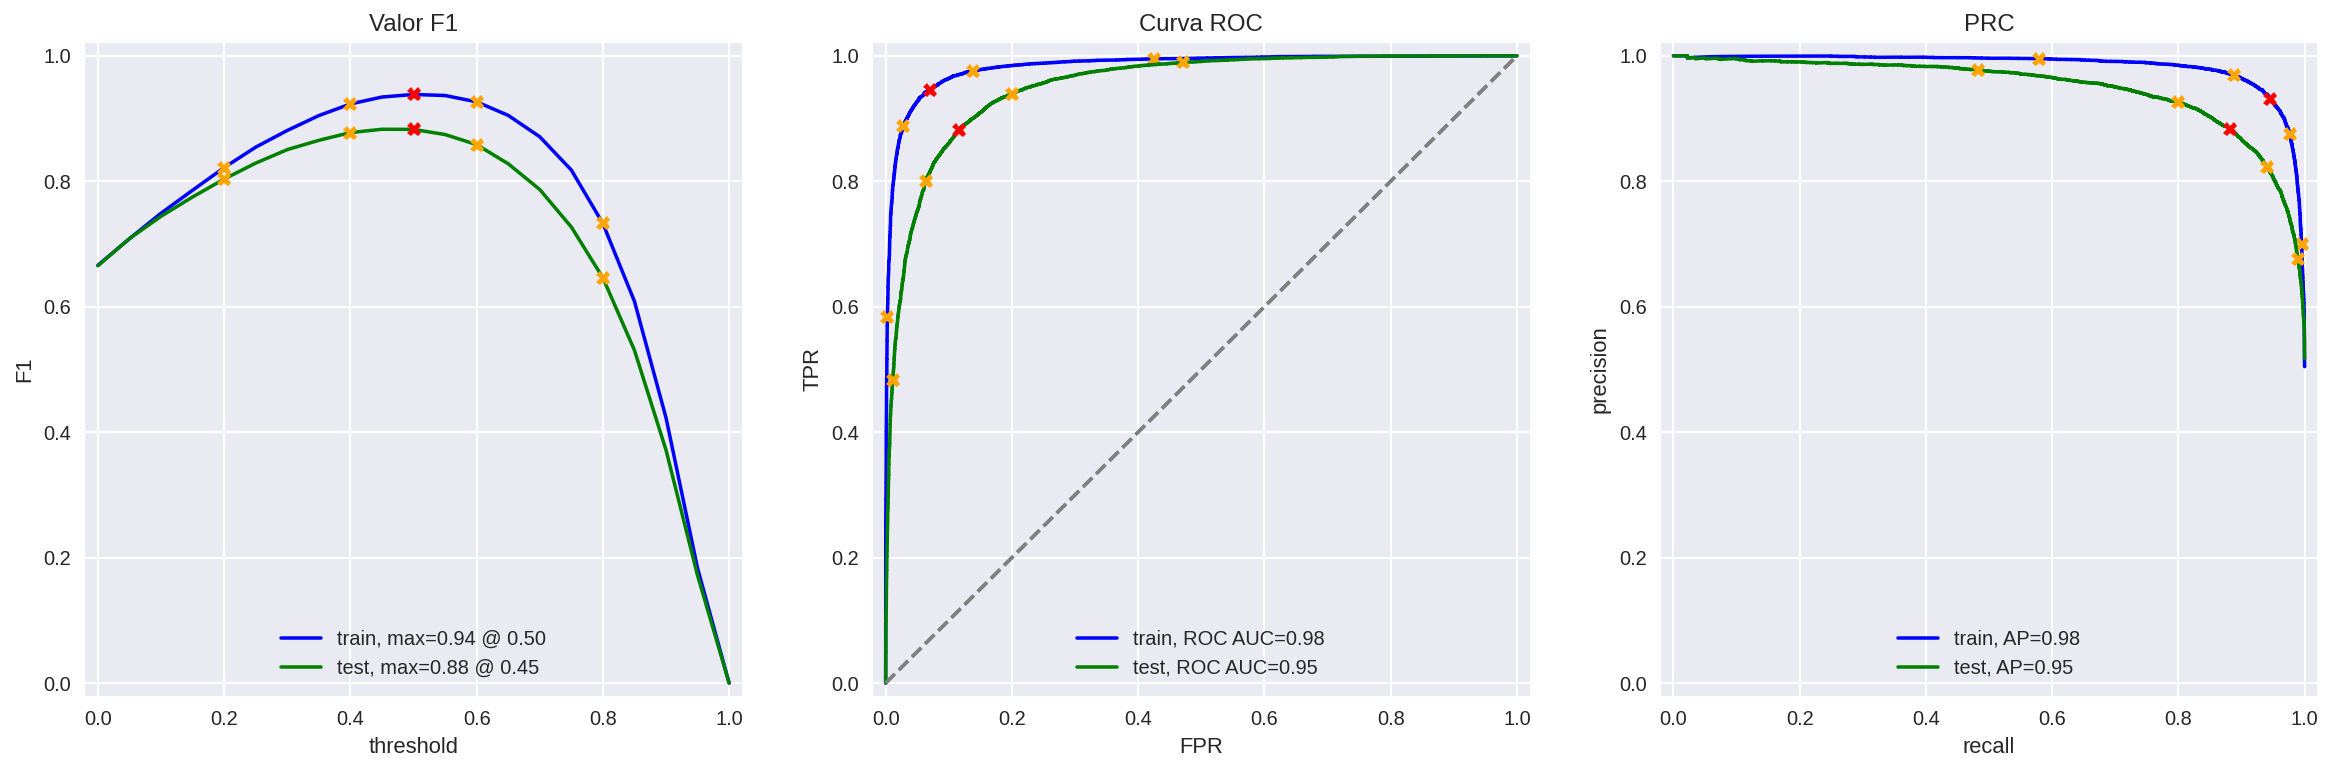

In [18]:
# Avaliar a performance do modelo usando a função evaluate_model()
evaluate_model(model1,train_features, train_target, test_features, test_target)

### Modelo 2 - spaCy, TF-IDF e Regressão Linear

In [19]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Definir uma função para extrair as palavras relevantes usando o spaCy
def extract_lemmas(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(lemmas)

# Aplicar a função de extração de palavras relevantes para as resenhas
df_reviews_train['lemmas'] = df_reviews_train['review_norm'].progress_apply(extract_lemmas)
df_reviews_test['lemmas'] = df_reviews_test['review_norm'].progress_apply(extract_lemmas)

# Criar um objeto TfidfVectorizer para extrair features dos textos
tfidf2 = TfidfVectorizer()

# Obter as matrizes de features para os dados de treinamento e teste
train_features = tfidf2.fit_transform(df_reviews_train['lemmas'])
test_features = tfidf2.transform(df_reviews_test['lemmas'])

# Criar um modelo de Regressão Logística
moldel2 = LogisticRegression()

# Treinar o modelo usando as matrizes de features e as variáveis de destino
moldel2.fit(train_features, train_target)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

LogisticRegression()

          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.98  0.94
ROC AUC    0.98  0.95


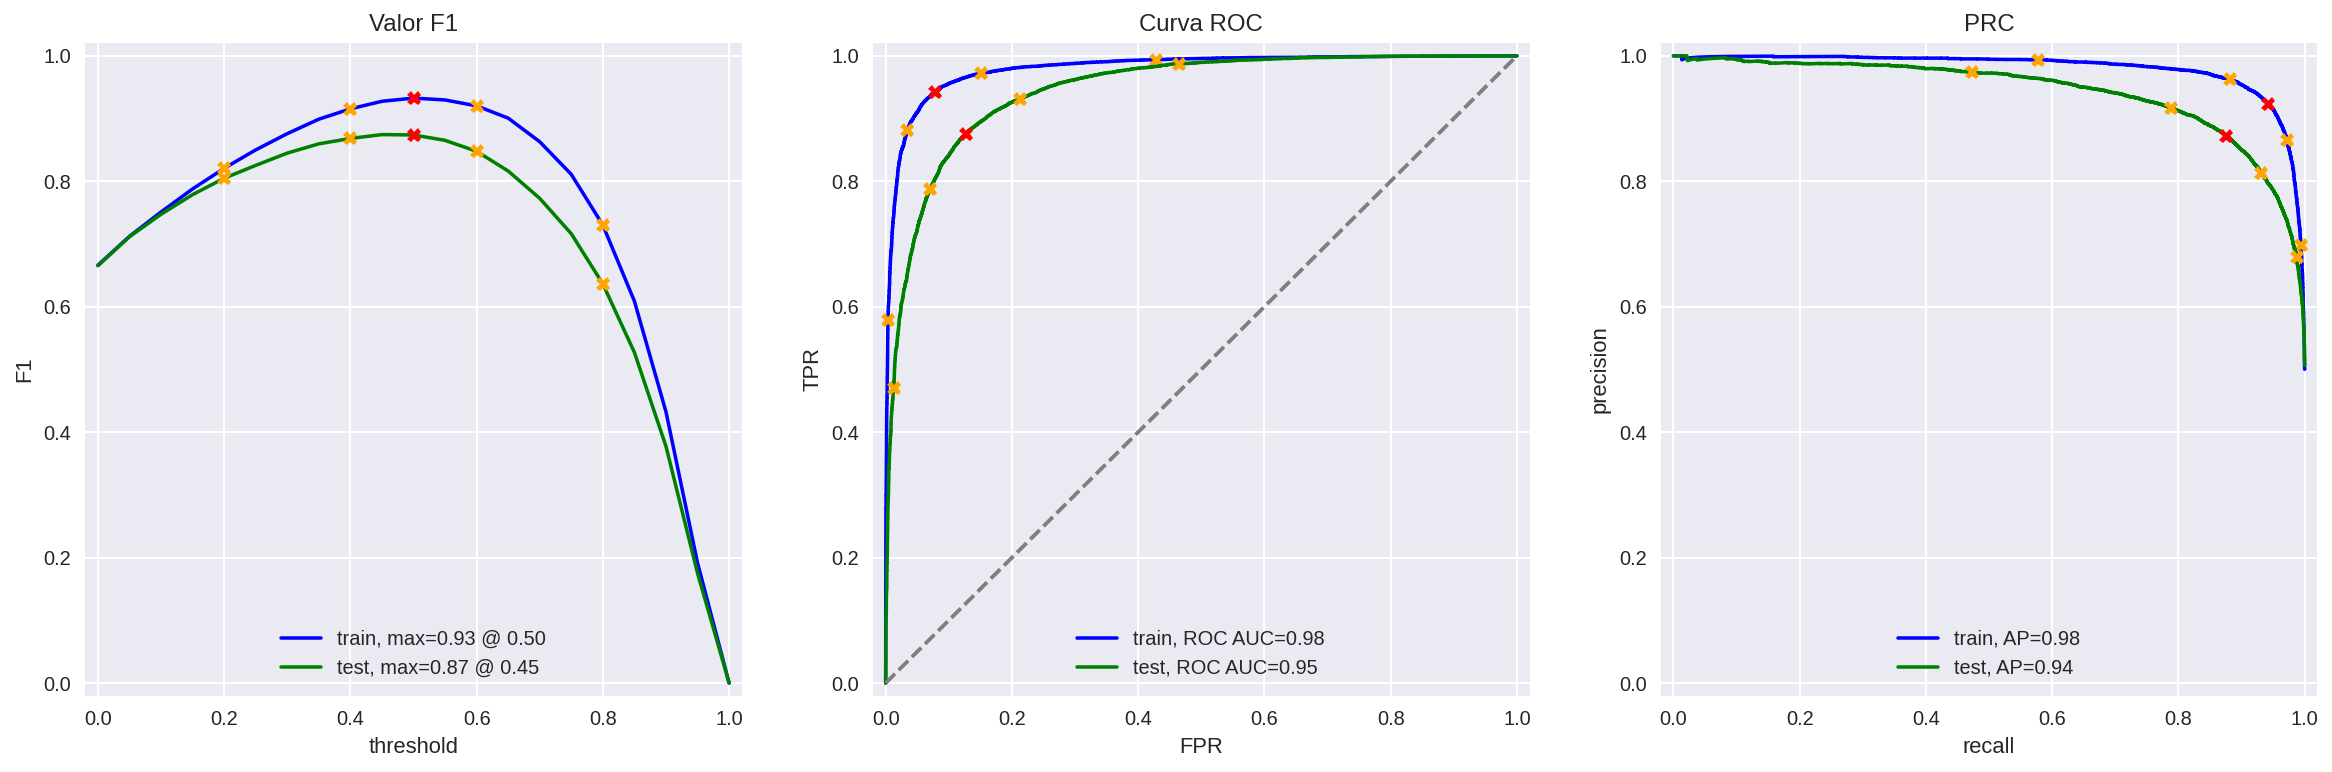

In [20]:
# Fazer previsões para os dados de teste
y_pred_lr = moldel2.predict(test_features)

# Avaliar a performance do modelo usando a função evaluate_model()
evaluate_model(moldel2,train_features, train_target, test_features, test_target)

### Modelo 3 - SpaCy, TF-IDF e LGBMClassifier

In [21]:
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Carregar o modelo do spaCy para a língua inglesa
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Definir uma função para extrair as palavras relevantes usando o spaCy
def extract_lemmas(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(lemmas)

# Aplicar a função de extração de palavras relevantes para as resenhas
df_reviews_train['lemmas'] = df_reviews_train['review_norm'].progress_apply(extract_lemmas)
df_reviews_test['lemmas'] = df_reviews_test['review_norm'].progress_apply(extract_lemmas)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.97  0.93
ROC AUC    0.97  0.93


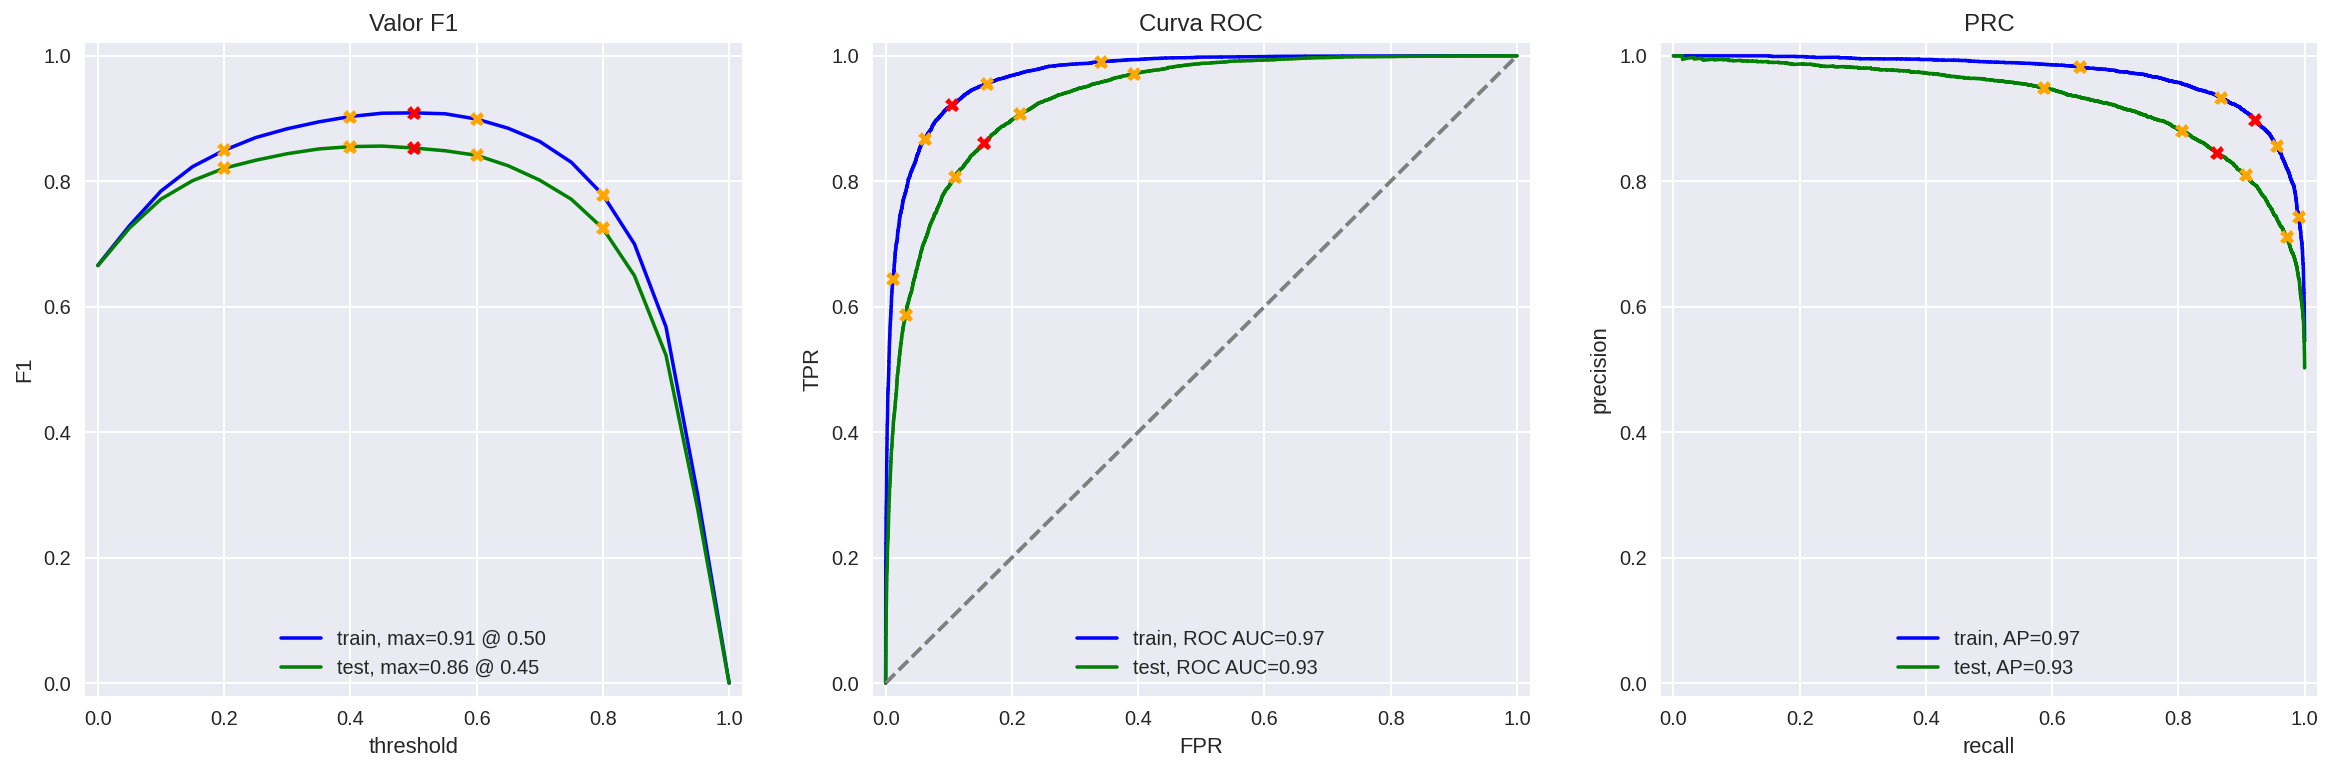

In [22]:
# Criar um objeto TfidfVectorizer para extrair features dos textos
tfidf3 = TfidfVectorizer()

# Obter as matrizes de features para os dados de treinamento e teste
train_features = tfidf3.fit_transform(df_reviews_train['lemmas'])
test_features = tfidf3.transform(df_reviews_test['lemmas'])

# Criar um modelo LGBMClassifier
model3 = LGBMClassifier()

# Treinar o modelo usando as matrizes de features e as variáveis de destino
model3.fit(train_features, train_target)

# Fazer previsões para os dados de teste
y_pred_lgbm = model3.predict(test_features)

# Avaliar a performance do modelo usando a função evaluate_model()
eval_results_lgbm = evaluate_model(model3, train_features, train_target, test_features, test_target)

## Minhas Resenhas

In [23]:
my_reviews = pd.DataFrame([
    'Eu simplesmente não gostei, não é meu tipo de filme.',
    'Bem, eu fiquei entediado e dormi no meio do filme.',
    'Eu fiquei realmente fascinado com o filme',    
    'Os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do filme. Que roubo de dinheiro sem vergonha.',
    'Eu não esperava que a nova versão fosse tão boa! Os escritores realmente se importaram com o material original',
    'O filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. Eu posso me imaginar indo assistir novamente.',
    'Que tentativa podre de comédia. Nem uma única piada cai, todo mundo age de forma irritante e barulhenta, nem crianças não vão gostar disso!',
    'Lançar na Netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após episódio, deste emocionante e inteligente novo drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

my_reviews

,review,review_norm
0,"Eu simplesmente não gostei, não é meu tipo de ...",eu simplesmente não gostei não é meu tipo de f...
1,"Bem, eu fiquei entediado e dormi no meio do fi...",bem eu fiquei entediado e dormi no meio do filme
2,Eu fiquei realmente fascinado com o filme,eu fiquei realmente fascinado com o filme
3,Os atores pareciam muito velhos e desinteressa...,os atores pareciam muito velhos e desinteressa...
4,Eu não esperava que a nova versão fosse tão bo...,eu não esperava que a nova versão fosse tão bo...
5,"O filme tem seus prós e contras, mas eu sinto ...",o filme tem seus prós e contras mas eu sinto q...
6,Que tentativa podre de comédia. Nem uma única ...,que tentativa podre de comédia nem uma única p...
7,Lançar na Netflix foi uma jogada corajosa e eu...,lançar na netflix foi uma jogada corajosa e eu...


In [24]:
my_reviews = pd.DataFrame([
'I just did not like it, not my type of movie.',
'Well, I got bored and fell asleep in the middle of the movie.',
'I was really fascinated by the movie.',
'The actors seemed very old and disinterested, yet they were still paid to participate in the movie. What a shameless money grab.',
'I did not expect the new version to be this good! The writers really cared about the original material.',
'The movie has its pros and cons, but I feel like overall it is a decent movie. I can see myself going to watch it again.',
'What a pathetic attempt at comedy. Not a single joke lands, everyone acts annoying and loud, not even kids would like this!',
'Releasing on Netflix was a bold move and I really appreciate being able to watch episode after episode of this thrilling and intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

my_reviews

,review,review_norm
0,"I just did not like it, not my type of movie.",i just did not like it not my type of movie
1,"Well, I got bored and fell asleep in the middl...",well i got bored and fell asleep in the middle...
2,I was really fascinated by the movie.,i was really fascinated by the movie
3,"The actors seemed very old and disinterested, ...",the actors seemed very old and disinterested y...
4,I did not expect the new version to be this go...,i did not expect the new version to be this go...
5,"The movie has its pros and cons, but I feel li...",the movie has its pros and cons but i feel lik...
6,What a pathetic attempt at comedy. Not a singl...,what a pathetic attempt at comedy not a single...
7,Releasing on Netflix was a bold move and I rea...,releasing on netflix was a bold move and i rea...


# Modelo 1

In [25]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model1.predict_proba(tfidf1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.48:  i just did not like it not my type of movie
0.21:  well i got bored and fell asleep in the middle of the movie
0.56:  i was really fascinated by the movie
0.20:  the actors seemed very old and disinterested yet they were still paid to participate in the movie wh
0.24:  i did not expect the new version to be this good the writers really cared about the original materia
0.60:  the movie has its pros and cons but i feel like overall it is a decent movie i can see myself going 
0.01:  what a pathetic attempt at comedy not a single joke lands everyone acts annoying and loud not even k
0.85:  releasing on netflix was a bold move and i really appreciate being able to watch episode after episo


## Modelo 2

In [26]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = moldel2.predict_proba(tfidf2.transform(texts.apply(lambda x: normalize_text(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.12:  i just did not like it not my type of movie
0.27:  well i got bored and fell asleep in the middle of the movie
0.49:  i was really fascinated by the movie
0.39:  the actors seemed very old and disinterested yet they were still paid to participate in the movie wh
0.44:  i did not expect the new version to be this good the writers really cared about the original materia
0.48:  the movie has its pros and cons but i feel like overall it is a decent movie i can see myself going 
0.06:  what a pathetic attempt at comedy not a single joke lands everyone acts annoying and loud not even k
0.84:  releasing on netflix was a bold move and i really appreciate being able to watch episode after episo


### Modelo 3

In [27]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model3.predict_proba(tfidf3.transform(texts.apply(lambda x: normalize_text(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.46:  i just did not like it not my type of movie
0.20:  well i got bored and fell asleep in the middle of the movie
0.61:  i was really fascinated by the movie
0.41:  the actors seemed very old and disinterested yet they were still paid to participate in the movie wh
0.56:  i did not expect the new version to be this good the writers really cared about the original materia
0.68:  the movie has its pros and cons but i feel like overall it is a decent movie i can see myself going 
0.11:  what a pathetic attempt at comedy not a single joke lands everyone acts annoying and loud not even k
0.85:  releasing on netflix was a bold move and i really appreciate being able to watch episode after episo


## Conclusões

Neste projeto, trabalhamos em um sistema de filtragem e categorização de resenhas de filmes, com o objetivo de treinar um modelo para detectar automaticamente resenhas negativas.

O modelo 1 utilizou a biblioteca NLTK para pré-processar os dados, a técnica de vetorização TF-IDF para representar as palavras nos textos e a regressão linear para classificar as resenhas.

Já o modelo 2 utilizou a biblioteca spaCy para pré-processar os dados, a mesma técnica de vetorização TF-IDF e a regressão linear para classificar as resenhas.

Por fim, o modelo 3 utilizou a biblioteca spaCy para pré-processar os dados, a técnica de vetorização TF-IDF e o algoritmo LGBMClassifier para classificar as resenhas.

É interessante observar que os modelos 2 e 3 utilizaram a mesma biblioteca para pré-processar os dados, mas utilizaram algoritmos diferentes para classificar as resenhas. Isso sugere que a escolha do algoritmo pode ser tão importante quanto a escolha das técnicas de pré-processamento e representação dos dados.

Com base nos resultados, selecionamos o modelo que melhor atendia aos nossos critérios de desempenho, o modelo 1, que apresentou um F1-score de 0,88.

# Checklist

- [x]  O caderno foi aberto
- [ ]  Os dados de texto são carregados e pré-processados para vetorização
- [ ]  Os dados de texto são transformados em vetores
- [ ]  Os modelos são treinados e testados
- [ ]  O limiar da métrica foi atingido
- [ ]  Todas as células de código estão organizadas na ordem de sua execução
- [ ]  Todas as células de código podem ser executadas sem erros
- [ ]  Há conclusões 